In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/hmeq-data/hmeq.csv


# **Trabalho de conclusao - Data Mining e Machine Learning II**

Sera apresentado a seguir estudo para base de emprestimo HMEQ.CSV, com analise exploratoria dos dados e modelo preditivo em random forest com e sem cross validation.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
#Importando dataset
df= pd.read_csv('/kaggle/input/hmeq-data/hmeq.csv')
df.shape


(5960, 13)

In [4]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4693 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Temos algumas colunas sem registro(NaN),principalmente a coluna de Debtinc com 1267 valores faltantes.

# Analise Exploratória

In [ ]:
graf1 = sns.barplot(x=df.BAD, y=df.BAD, data=df, estimator=lambda x: len(x) / len(df) * 100)
graf1.set(ylabel="Percent")

20% dos Clientes sao maus pagadores 

In [ ]:
sns.distplot(df.LOAN.dropna())
plt.title('Distribuição de quantidade de emprestimo')
plt.xlabel('Valor')
plt.ylabel('Quantidade')


In [ ]:
sns.distplot(df.MORTDUE.dropna())
plt.title('Distribição do valor do empréstimo ')
plt.ylabel('Quantidade')
plt.xlabel('Valor da divida')

In [ ]:
sns.distplot(df.VALUE.dropna())
plt.title('Distribuição do valor do imovel')
plt.xlabel('Valor')
plt.ylabel('Quantidade')

In [ ]:
plt.title('Distribuiçao de anos de trabalho')
sns.distplot(df.YOJ.dropna())
plt.xlabel('Anos trabalhaos')
plt.ylabel('Quantidade')

In [ ]:
a = df.REASON.copy()
a[pd.isnull(a)==True] = 'Missing'
sns.countplot(a, hue = df.BAD)
plt.title('Status de Emprestimo para pagar outro emprestimo')
plt.xlabel('Motivo')
plt.ylabel('Quantidade')

In [ ]:
b = df.JOB.copy()
b[pd.isnull(b)==True] = 'Missing'
sns.countplot(b, hue= df.BAD)
plt.title('Emprestimo por Cargo')
plt.ylabel('Quantidade')
plt.xlabel('Cargo')

A marioria dos emprestimos sao para pagamento de outras dividas, o maior volume de pessos que procuram emprestimos tem o cargo classificados como outros

In [ ]:
def dist_boxplot(x, **kwargs):
    ax = sns.distplot(x, hist_kws=dict(alpha=0.2))
    ax2 = ax.twinx()
    sns.boxplot(x=x, ax=ax2)
    ax2.set(ylim=(-5, 5))

g = sns.FacetGrid(df, col="BAD")
g1 = g.map(dist_boxplot, 'CLAGE', data = df)

g = sns.FacetGrid(df, col="BAD")
g2 = g.map(dist_boxplot, 'NINQ', data = df)

g = sns.FacetGrid(df, col="BAD")
g3 = g.map(dist_boxplot, 'CLNO', data = df)

g = sns.FacetGrid(df, col="BAD")
g4 = g.map(dist_boxplot, 'DEBTINC', data = df)

As variaveis CLAGE, NINQ, CLNO e DEBTINC parecem variar bastante em relação à variável BAD e podem servir como possíveis preditores.

**Substituindo valores faltantes em Dectinc

In [31]:
# input de valores na varial DEBTINC pela media de acordo com a descrição da coluna REASON
df.loc[(df.REASON == 'HomeImp') & (pd.isnull(df.DEBTINC) == True),'DEBTINC'] = np.mean(df.loc[df.REASON == 'HomeImp','DEBTINC'])
df.loc[(df.REASON == 'DebtCon') & (pd.isnull(df.DEBTINC) == True),'DEBTINC'] = np.mean(df.loc[df.REASON == 'DebtCon','DEBTINC'])
df.loc[(pd.isnull(df.REASON) == True) & (pd.isnull(df.DEBTINC) == True),'DEBTINC'] = np.mean(df.loc[pd.isnull(df.REASON) == True,'DEBTINC'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    5960 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [32]:
#input de 0 para valores faltantes na coluna de credito inadimplente 
df.loc[pd.isnull(df.DELINQ)==True, 'DELINQ'] = 0
df.loc[pd.isnull(df.JOB)==True, 'JOB'] = 'Missing'

In [33]:
df.isnull().sum()

BAD          0
LOAN         0
MORTDUE    518
VALUE      112
REASON     252
JOB          0
YOJ        515
DEROG      708
DELINQ       0
CLAGE      308
NINQ       510
CLNO       222
DEBTINC      0
dtype: int64

In [35]:
df = df.fillna(0)

In [36]:
df.shape

(5960, 13)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5960 non-null float64
VALUE      5960 non-null float64
REASON     5960 non-null object
JOB        5960 non-null object
YOJ        5960 non-null float64
DEROG      5960 non-null float64
DELINQ     5960 non-null float64
CLAGE      5960 non-null float64
NINQ       5960 non-null float64
CLNO       5960 non-null float64
DEBTINC    5960 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


## Criando Modelo de Random Forest

In [38]:

import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scikitplot as skplt
from sklearn.model_selection import cross_val_score

Criando um novo dataframe para o modelo de random forest com inclusao de colunas dummy

In [39]:
df_rf = pd.get_dummies(df, df.dtypes[(df.dtypes==np.object) | (df.dtypes=='category')].index.values, drop_first=True)
df_rf.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Missing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,33.280063,0,1,0,0,1,0,0,0
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,33.280063,0,1,0,0,1,0,0,0
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,33.280063,0,1,0,0,1,0,0,0
3,1,1500,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,28.830722,0,0,1,0,0,0,0,0
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,33.280063,0,1,0,1,0,0,0,0


Separado o novo dataframe em traino e teste

In [40]:
train, test = train_test_split(df_rf, test_size=0.20, random_state=42)

separando o base treino em treino e validação

In [41]:
train, valid = train_test_split(train, test_size=0.20, random_state=42)

train.shape, valid.shape, test.shape

((3814, 19), (954, 19), (1192, 19))

In [42]:
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 19 columns):
BAD               5960 non-null int64
LOAN              5960 non-null int64
MORTDUE           5960 non-null float64
VALUE             5960 non-null float64
YOJ               5960 non-null float64
DEROG             5960 non-null float64
DELINQ            5960 non-null float64
CLAGE             5960 non-null float64
NINQ              5960 non-null float64
CLNO              5960 non-null float64
DEBTINC           5960 non-null float64
REASON_DebtCon    5960 non-null uint8
REASON_HomeImp    5960 non-null uint8
JOB_Missing       5960 non-null uint8
JOB_Office        5960 non-null uint8
JOB_Other         5960 non-null uint8
JOB_ProfExe       5960 non-null uint8
JOB_Sales         5960 non-null uint8
JOB_Self          5960 non-null uint8
dtypes: float64(9), int64(2), uint8(8)
memory usage: 558.9 KB


### **Incio do modelo de Random Forest**

In [119]:
rf = RandomForestClassifier(n_jobs=-1, oob_score=True, n_estimators = 150, random_state=150)

In [101]:
feats = [c for c in df_rf.columns if c not in ['BAD']]
feats

['LOAN',
 'MORTDUE',
 'VALUE',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC',
 'REASON_DebtCon',
 'REASON_HomeImp',
 'JOB_Missing',
 'JOB_Office',
 'JOB_Other',
 'JOB_ProfExe',
 'JOB_Sales',
 'JOB_Self']

In [120]:
rf.fit(train[feats],train['BAD'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=150, verbose=0,
                       warm_start=False)

In [121]:
# Prevendo os dados de validação
preds_val = rf.predict(valid[feats])


In [123]:
accuracy_score(valid['BAD'], preds_val)

1.0

In [124]:
preds_test = rf.predict(test[feats])

preds_test

array([0, 0, 0, ..., 0, 0, 0])

In [125]:
accuracy_score(test['BAD'], preds_test)

0.9219798657718121

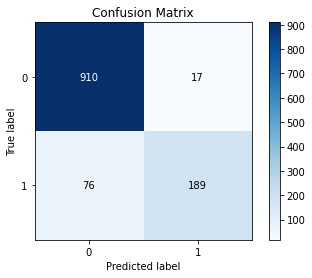

In [126]:
skplt.metrics.plot_confusion_matrix(test['BAD'], preds_test)

Apos a primeira tentativa usando o modelo de random forest, é possivel observar uma acuracia de 91% considerado muito boa para o modelo.

## Revendo Random Forest utilizando Cross Validation

In [110]:
train, test = train_test_split(df_rf, test_size=0.20, random_state=42)
train.shape, test.shape

((4768, 19), (1192, 19))

In [111]:
scores = cross_val_score(rf, train[feats], train['BAD'], n_jobs=-1, cv=5)

scores, scores.mean()

(array([0.91404612, 0.92557652, 0.92662474, 0.92759706, 0.92654774]),
 0.9240784370662214)

In [115]:
scores = cross_val_score(rf, test[feats], test['BAD'], n_jobs=-1, cv=5)

scores, scores.mean()

(array([0.89539749, 0.90794979, 0.88235294, 0.8907563 , 0.8907563 ]),
 0.893442565310643)

Apos a realização do random foreste usando o metodo de validação cruzada de 5 conjuntos, obtivemos 92,4% de acuracia na base de treino,1% melhor que o primeito modelo de random forest testado anteriormente. Quando aplicando o mesmo modelo na base de teste tivemos o resultado de 89,3 que ainda assim é condiderado um bom modelo.